In [25]:
%matplotlib inline

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

import tensorflow as tf
import pickle
import os
import random
import glob
import sys
import datetime
import wispy
import wispy.resnet
import wispy.logger
import wispy.utils
import wispy.callbacks
import wispy.model_utils
from tomlkit import parse
from tensorflow.keras.utils import get_custom_objects
import pugna.activations

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
sys.path.append("../../")

In [3]:
import fit

In [4]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [5]:
glob.glob("001/*.h5")

['001/model.h5']

In [6]:
config_file = "config_001.toml"

In [7]:
with open(config_file, "r") as f:
    text = f.read()

doc = parse(text)

In [8]:
doc['data']['train_root_dir']

'../training_data'

In [9]:
doc['data']['data_to_model']

'phis'

In [10]:
filename = doc['data']['y_preprocessing_params_file']
y_processing_params = np.load(filename)

In [11]:
dict(y_processing_params)

{'alpha': array(28.86180926),
 'amp_21': array(0.09169457),
 'amp_22': array(0.39615992),
 'beta': array(1.45721988),
 'gamma': array(29.11021112),
 'phi_21': array(97.00054714),
 'phi_22': array(154.30959149)}

In [12]:
y_train_phi_22 = fit.load_coprec_data_and_apply_preproc(doc['data']['train_root_dir'], 'phi_22', y_processing_params)
y_train_phi_21 = fit.load_coprec_data_and_apply_preproc(doc['data']['train_root_dir'], 'phi_21', y_processing_params)

In [13]:
y_train_phi_22.shape

(1000, 1219)

In [26]:
filename = doc['data']['times_file']
times = np.load(filename)

pkl_filename = doc['data']['times_scaler']
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

times_scaled = times_scaler.transform(times[:, np.newaxis])

In [27]:
plt.figure()
plt.plot(times_scaled, y_train_phi_22[0])

In [28]:
filename = doc['data']['coords_train_file']
coords_train = np.load(filename).T

In [29]:
def get_input_for_ann(times, coords):
    return np.column_stack((times[:, 0], (coords*np.ones(times.shape))))

In [30]:
X = get_input_for_ann(times_scaled, coords_train[0])

In [31]:
X.shape

(1219, 8)

In [32]:
coords_train.shape

(1000, 7)

In [33]:
model = tf.keras.models.load_model('001/model.h5',
                                   custom_objects={'ScaleLayer': wispy.mscalev3.ScaleLayer}
                                  )

In [41]:
def compare(index, model, times_scaled, coords, phi_22, phi_21):
    print(coords[index])
    X = get_input_for_ann(times_scaled, coords[index])
    yhat = model.predict(X)
    
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    plt.plot(times_scaled, phi_22[index], label='data')
    plt.plot(times_scaled, yhat[:,0], label='model')
    plt.title('phi_22')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(times_scaled, phi_21[index], label='data')
    plt.plot(times_scaled, yhat[:,1], label='model')
    plt.title('phi_21')
    plt.legend()
    
    plt.show()
    plt.close()

In [42]:
compare(1, model, times_scaled, coords_train, y_train_phi_22, y_train_phi_21)

[1.92082761 0.71312307 2.08319771 5.90529234 0.35971307 2.27650738
 3.01086093]


727
[3.30038937 0.14435    2.65760891 5.46409212 0.21288132 0.70533883
 1.53220481]


235
[3.07498182 0.56380094 2.73065194 5.71340275 0.64441958 1.34558804
 1.14380799]


977
[2.67466562 0.61255491 1.55710679 6.15046001 0.81126018 2.10382445
 5.90791066]


806
[2.27530513 0.41894031 2.12028451 3.62873243 0.31802062 2.0583978
 5.84296464]


978
[2.74239379 0.83069205 1.54387907 1.59751381 0.36176794 2.94064465
 5.72741489]


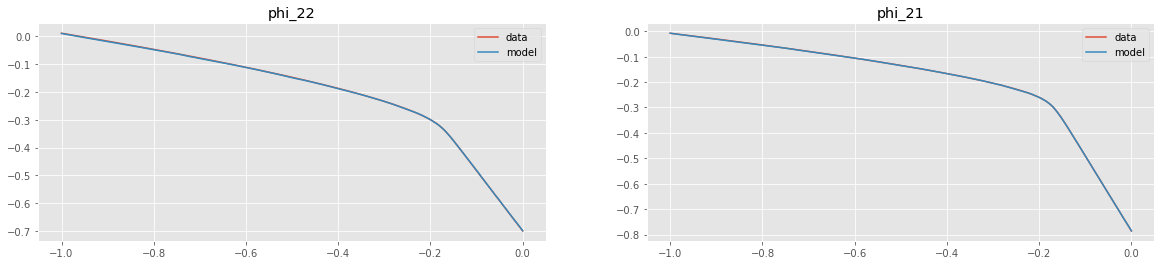

570
[1.48391687 0.69671974 0.30739838 2.47922564 0.06805698 0.27093088
 3.06224179]


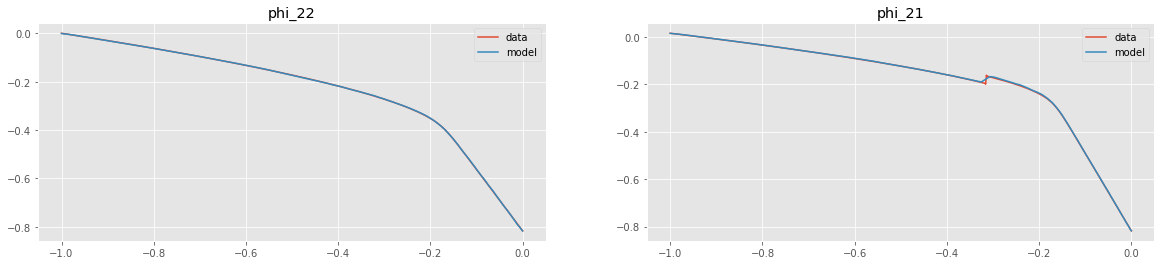

897
[2.97165493 0.62646596 2.44810015 1.33029644 0.95035937 0.88485107
 1.15820122]


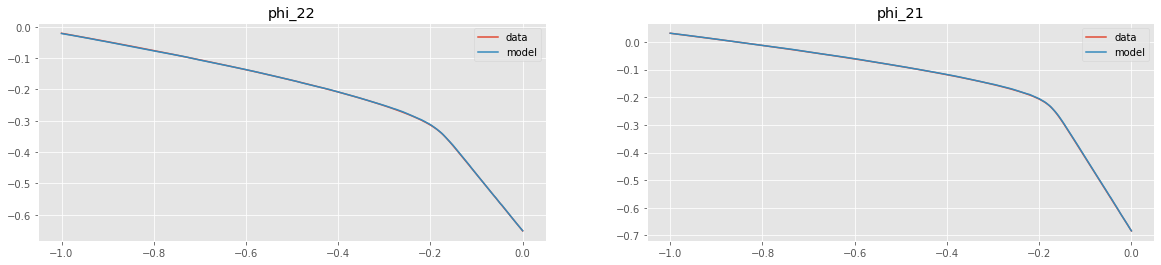

217
[1.97118815 0.71542954 0.69914652 1.54735274 0.49347279 1.19120035
 5.18776215]


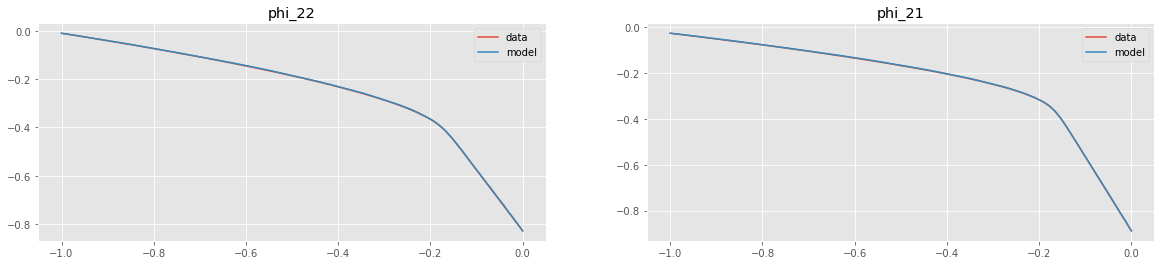

25
[3.86202011 0.62749705 0.55528461 1.11285921 0.67043888 2.09297079
 0.27519067]


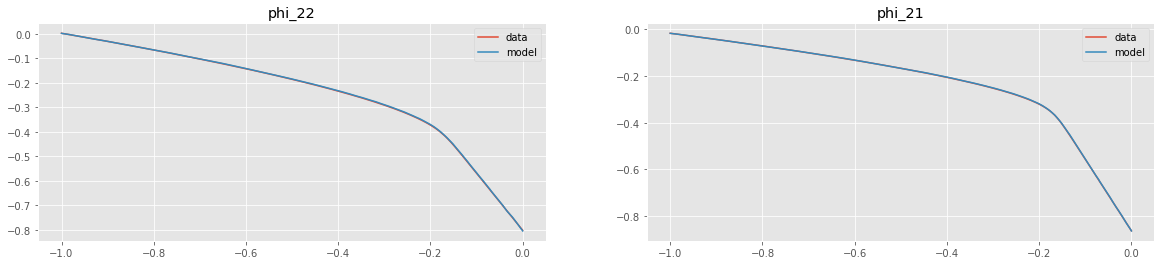

336
[2.89681844 0.83386729 2.17336899 0.47241951 0.95509698 0.29396615
 5.22742989]


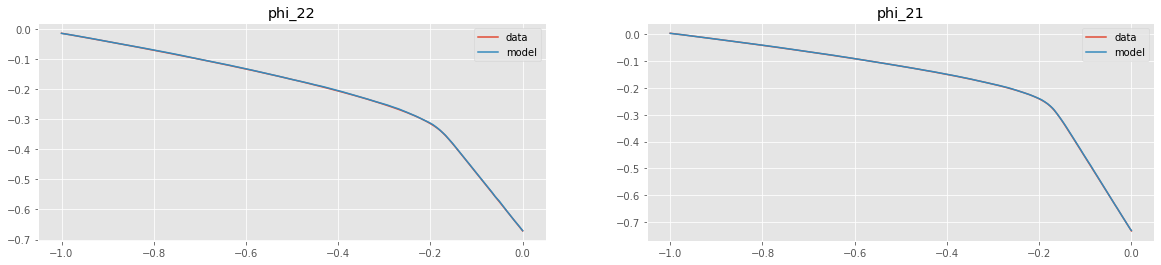

In [43]:
for i in random.sample(range(len(coords_train)), 10):
    print(i)
    compare(i, model, times_scaled, coords_train, y_train_phi_22, y_train_phi_21)